# Nickolas4 - Capital Market Line

In [1]:
import numpy as np
import pandas as pd
from pandas_datareader import DataReader as dr
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize as sco
import scipy.interpolate as sci

In [2]:
#Generate portfolio
symbols = ['AAPL', 'MSFT', 'TLT', 'USO', 'GLD', 
           'SPY', 'CAT', 'KO', 'WMT', 'EMB']
asset_count = len(symbols)

In [3]:
#Empty DF to store web data
nickolas4 = pd.DataFrame()

In [4]:
risk_free = dr('^IRX', data_source='yahoo', 
                       start='2010-01-01')['Adj Close']/100
risk_free.tail()

Date
2017-04-26    0.00803
2017-04-27    0.00785
2017-04-28    0.00780
2017-05-01    0.00785
2017-05-02    0.00843
Name: Adj Close, dtype: float64

In [5]:
#Add 10 historic asset returns from Yahoo
for i in symbols:
    nickolas4[i] = dr(i, data_source='yahoo', 
    start='2010-01-01', end='2015-01-01')['Adj Close'].round(2)
nickolas4.columns = symbols

nickolas4.tail()

,AAPL,MSFT,TLT,USO,GLD,SPY,CAT,KO,WMT,EMB
Date,,,,,,,,,,
2014-12-24,107.27,45.34,117.29,21.05,112.77,198.43,85.33,39.90,81.12,99.73
2014-12-26,109.17,45.09,117.73,20.78,114.83,199.07,85.79,39.92,81.57,99.66
2014-12-29,109.09,44.69,118.61,20.30,113.67,199.33,85.32,39.82,81.32,99.17
2014-12-30,107.76,44.28,118.93,20.29,115.20,198.26,84.30,39.73,81.46,99.44
2014-12-31,105.71,43.75,119.16,20.36,113.58,196.30,83.34,39.23,80.61,98.68


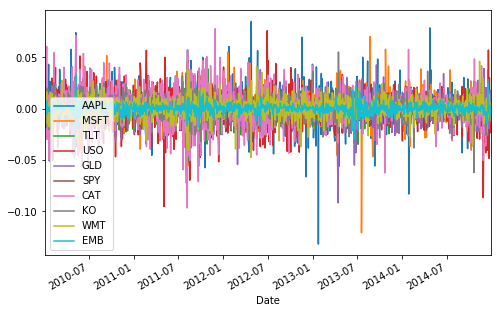

In [6]:
#DF of Logarithim Returns
n4_log = np.log(nickolas4/nickolas4.shift(1))
n4_log.plot(figsize=(8,5))

In [7]:
def statistics(weights):
    ''' Return portfolio statistics.
    
    Parameters
    ==========
    weights : array-like
        weights for different securities in portfolio
    
    Returns
    =======
    pret : float
        expected portfolio return
    pvol : float
        expected portfolio volatility
    pret / pvol : float
        Sharpe ratio for rf=0
    '''
    weights = np.array(weights)
    pret = np.sum(n4_log.mean() * weights) * 252
    pvol = np.sqrt(np.dot(weights.T, np.dot(n4_log.cov() * 252, weights)))
    return np.array([pret, pvol, pret / pvol])

In [8]:
weights = np.random.random(len(n4_log.columns))  #generate 10 random numbers between 0 and 1
weights /= np.sum(weights)       #normalize values so that sum = 1 

In [9]:
#Iterations
prets = []
pvols = []
for p in range (2500):
    weights = np.random.random(asset_count)
    weights /= np.sum(weights)
    prets.append(np.sum(n4_log.mean() * weights) * 252)
    pvols.append(np.sqrt(np.dot(weights.T, 
                        np.dot(n4_log.cov() * 252, weights))))
prets = np.array(prets)
pvols = np.array(pvols)

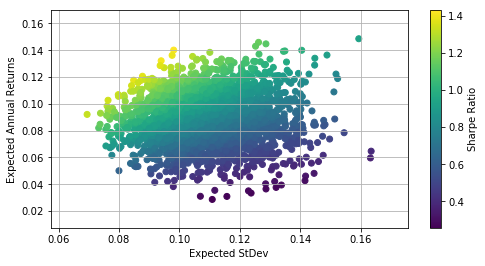

In [10]:
#Monte Carlo Simulation values
plt.figure(figsize=(8,4))
plt.scatter(pvols, prets, c = prets/pvols, marker = 'o')
plt.grid(True)
plt.xlabel("Expected StDev")
plt.ylabel('Expected Annual Returns')
plt.colorbar(label = 'Sharpe Ratio')

In [11]:
#Optimization Constraints
cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})

#Boundary values
bnds = tuple((0, 1) for x in weights)

In [12]:
#Optimization Functions
def min_func_port(weights):
    return statistics(weights)[1]

#Maximize Sharpe Volatility
def maximize_sharpe(weights):
    return -statistics(weights)[2]

#Minimize Variance
def minimize_variance(weights):
    return statistics(weights)[1] ** 2

In [13]:
%%time
trets = np.linspace(0.0, 0.25, 50)
tvols = []
for tret in trets:
    cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    res = sco.minimize(min_func_port, asset_count * [1. / asset_count,], method='SLSQP',
                       bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

CPU times: user 13.8 s, sys: 19 ms, total: 13.8 s
Wall time: 13.8 s


In [14]:
#Optimization Objects
opt_variance = sco.minimize(minimize_variance, asset_count * [1. / asset_count,], method='SLSQP',
                       bounds=bnds, constraints=cons)

opt_sharpe = sco.minimize(maximize_sharpe, asset_count * [1. / asset_count,], method='SLSQP',
                       bounds=bnds, constraints=cons)

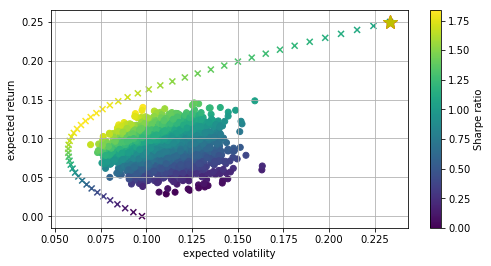

In [15]:
#Efficient Frontier
plt.figure(figsize=(8, 4))
plt.scatter(pvols, prets,
            c=prets / pvols, marker='o')
            # random portfolio composition
plt.scatter(tvols, trets,
            c=trets / tvols, marker='x')
            # efficient frontier
plt.plot(statistics(opt_sharpe['x'])[1], statistics(opt_sharpe['x'])[0],
         'r*', markersize=15.0)
            # portfolio with highest Sharpe ratio
plt.plot(statistics(opt_variance['x'])[1], statistics(opt_variance['x'])[0],
         'y*', markersize=15.0)
            # minimum variance portfolio
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

# 5.) Capital Market Line
* A tangent line of the efficient frontier taht goes through the risk-return point of the riskless portfolio. 

* For example, consider a riskless rate of rf = 0.01. We look for that portfolio on the efficient frontier for which the tangent goes through the point (stdev*rf)=(0, 0.01) in risk-return space.

* For the calculation to follow, we need a functional approximation and the first derivative for the efficient frontier. We use cubic splines interpolation to this end. 

In [16]:
#For spline interpolation, only use the portfolios from the efficient frontier. 
#The following code selects these portfolios from our previously used sets tvols & trets

ind = np.argmin(tvols)
evols = tvols[ind:]
erets = trets[ind:]

In [17]:
tck = sci.splrep(evols, erets)

In [18]:
tck

(array([ 0.05721776,  0.05721776,  0.05721776,  0.05721776,  0.0579892 ,
         0.05891673,  0.06025836,  0.06202555,  0.06418348,  0.06669528,
         0.06952342,  0.07262762,  0.07600711,  0.07999065,  0.08459731,
         0.08973042,  0.09531083,  0.10129316,  0.10761397,  0.11421702,
         0.12105646,  0.12809294,  0.13529777,  0.14264389,  0.15011458,
         0.15768295,  0.1653492 ,  0.17314617,  0.18117608,  0.18944097,
         0.19791141,  0.20656211,  0.21537135,  0.23339333,  0.23339333,
         0.23339333,  0.23339333]),
 array([ 0.08673469,  0.09466187,  0.09684131,  0.10332587,  0.10765517,
         0.11279593,  0.11770648,  0.12275284,  0.12778602,  0.13284987,
         0.13821028,  0.14321468,  0.14823154,  0.15327034,  0.1583407 ,
         0.16340405,  0.16847803,  0.17355867,  0.1786433 ,  0.1837338 ,
         0.18882446,  0.19392102,  0.19901176,  0.20411441,  0.20922435,
         0.21436451,  0.2194611 ,  0.22455225,  0.2296454 ,  0.23474009,
         0.2415

In [19]:
def f(x):
    ''' Efficient frontier function (splines approximation). '''
    return sci.splev(x, tck, der=0)
def df(x):
    ''' First derivative of efficient frontier function. '''
    return sci.splev(x, tck, der=1)

In [20]:
def equations(p, rf=0.01):
    eq1 = rf - p[0]
    eq2 = rf + p[1] * p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3

In [21]:
opt = sco.fsolve(equations, [0.01, 0.5, 0.15])

In [22]:
opt

array([ 0.01      ,  0.82695296,  0.46166418])

In [23]:
np.round(equations(opt), 6)

array([ 0., -0., -0.])

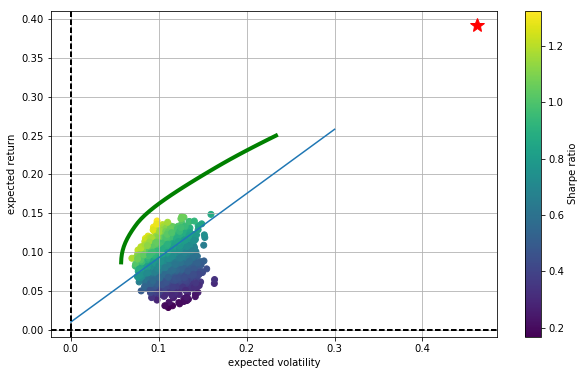

In [24]:
plt.figure(figsize=(10, 6))
plt.scatter(pvols, prets,
            c=(prets - 0.01) / pvols, marker='o')
            # random portfolio composition
plt.plot(evols, erets, 'g', lw=4.0)
            # efficient frontier
cx = np.linspace(0.0, 0.3)
plt.plot(cx, opt[0] + opt[1] * cx, lw=1.5)
            # capital market line
plt.plot(opt[2], f(opt[2]), 'r*', markersize=15.0) 
plt.grid(True)
plt.axhline(0, color='k', ls='--', lw=2.0)
plt.axvline(0, color='k', ls='--', lw=2.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe ratio')

In [25]:
cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - f(opt[2])},
        {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
res = sco.minimize(min_func_port, asset_count * [1. / asset_count,], method='SLSQP',
                       bounds=bnds, constraints=cons)

In [26]:
res['x'].round(3)

array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [27]:
tck

(array([ 0.05721776,  0.05721776,  0.05721776,  0.05721776,  0.0579892 ,
         0.05891673,  0.06025836,  0.06202555,  0.06418348,  0.06669528,
         0.06952342,  0.07262762,  0.07600711,  0.07999065,  0.08459731,
         0.08973042,  0.09531083,  0.10129316,  0.10761397,  0.11421702,
         0.12105646,  0.12809294,  0.13529777,  0.14264389,  0.15011458,
         0.15768295,  0.1653492 ,  0.17314617,  0.18117608,  0.18944097,
         0.19791141,  0.20656211,  0.21537135,  0.23339333,  0.23339333,
         0.23339333,  0.23339333]),
 array([ 0.08673469,  0.09466187,  0.09684131,  0.10332587,  0.10765517,
         0.11279593,  0.11770648,  0.12275284,  0.12778602,  0.13284987,
         0.13821028,  0.14321468,  0.14823154,  0.15327034,  0.1583407 ,
         0.16340405,  0.16847803,  0.17355867,  0.1786433 ,  0.1837338 ,
         0.18882446,  0.19392102,  0.19901176,  0.20411441,  0.20922435,
         0.21436451,  0.2194611 ,  0.22455225,  0.2296454 ,  0.23474009,
         0.2415